# Azure Language Service - Question Answering

In [ ]:
# Importing library to view image
from IPython.display import Image as img

## There are various services offered under the umbrella of Azure Cognitive Services. We have studied Azure Vision Services briefly in the past. In this session, we are going to explore Azure Language Services. As is shown in the flowchart below, there are several use cases under Language Services as well; which are determined by the data type, i.e. speech will processed differently from the written word.

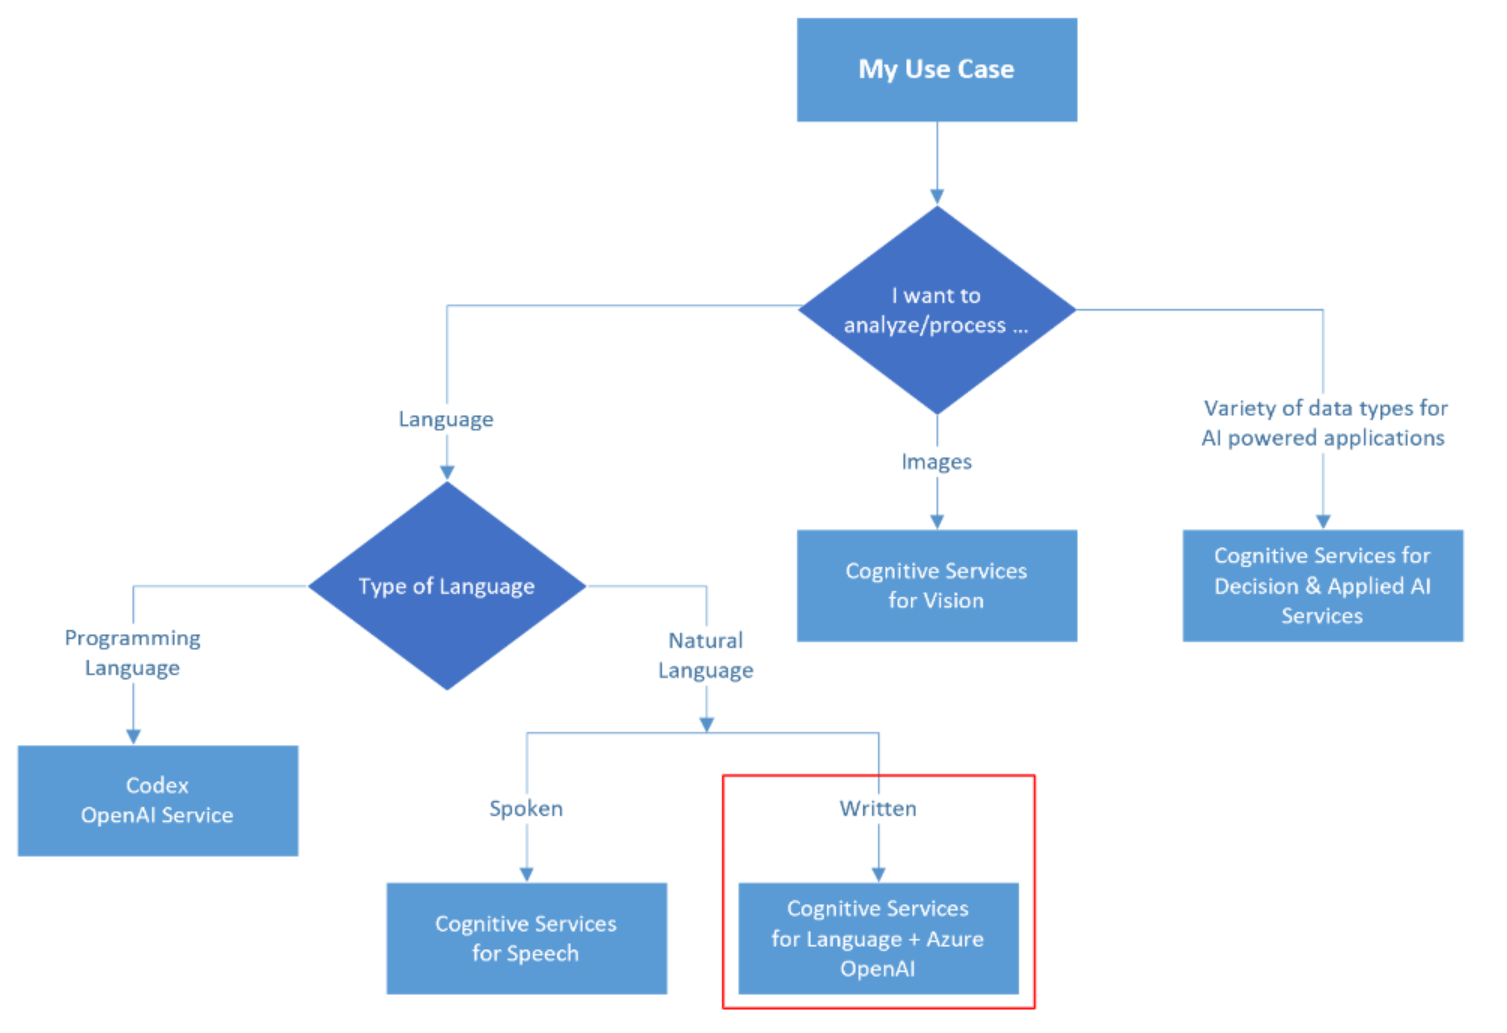

In [ ]:
img('theory1.png')

## Under the specific use case of text, there are further sub-divisions, based on the type of processing applied to analyse the same.

### There are five major umbrellas under the Language Cognitive Services:
#### 1. Extract information.
#### 2. Classify text
#### 3. Understand questions and conversational language.
#### 4. Summarize text.
#### 5. Translate text.

### In the present course, we are limited to exploring the use case of understanding questions, and conversational language.

### In this file, we will explore how to create a corpus of questions and answers, and how to use it. In the second part of the present session, we will explore the second half of this application, namely, how to understand conversational language using Azure.

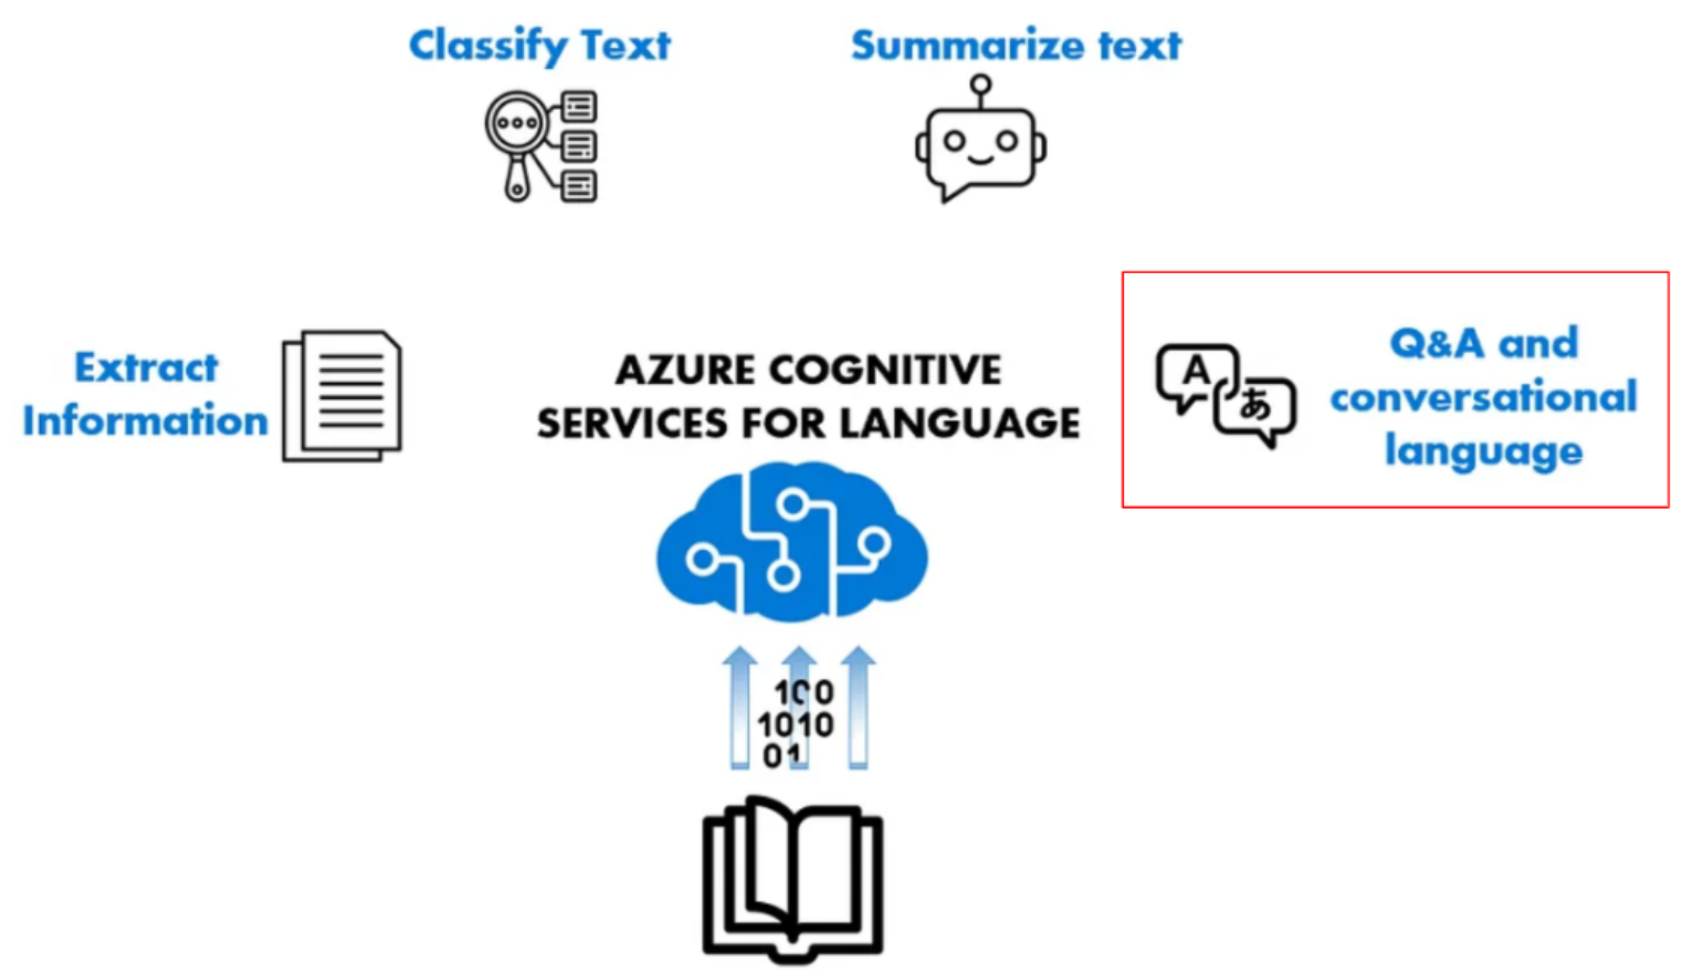

In [ ]:
img('theory2.png')

# Prerequisites:

## 1. Install the necessary libraries:

In [ ]:
# https://learn.microsoft.com/en-us/python/api/overview/azure/ai-language-questionanswering-readme?view=azure-python

In [ ]:
# Install the azure question answering library
!pip install azure-ai-language-questionanswering

# dotenv library
!pip install python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.1/113.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.4/193.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.7 MB/s eta 0:00:00


## 2. Import the required libraries:

In [ ]:
# To read the secret keys for Authentication
import os
from dotenv import load_dotenv
from azure.core.credentials import AzureKeyCredential

# To create new project
from azure.ai.language.questionanswering.authoring import AuthoringClient

# to create a question-answering client, and to ask questions using the knowledge base
from azure.ai.language.questionanswering import QuestionAnsweringClient
from azure.ai.language.questionanswering import models as qna

## 3. Create a Language resource in your resource group (Azure Portal):

## Go to your resource group in Azure Portal https://portal.azure.com/
> ### Create new language service resource.
> ### Select both options for your language resource:
 1. Custom Question Answering
 2. Custom text classification etc.

**Note:**
  1. To execute the Q&A maker, we just need the Custom Question answering service. However, as we will continue this case study in the next part to create a Conversational Language Understanding model, we are selecting both the options.
  2. If you have an existing Language resource in the Free Tier (irrespective of the features selected), you cannot create a new resource in the same tier.



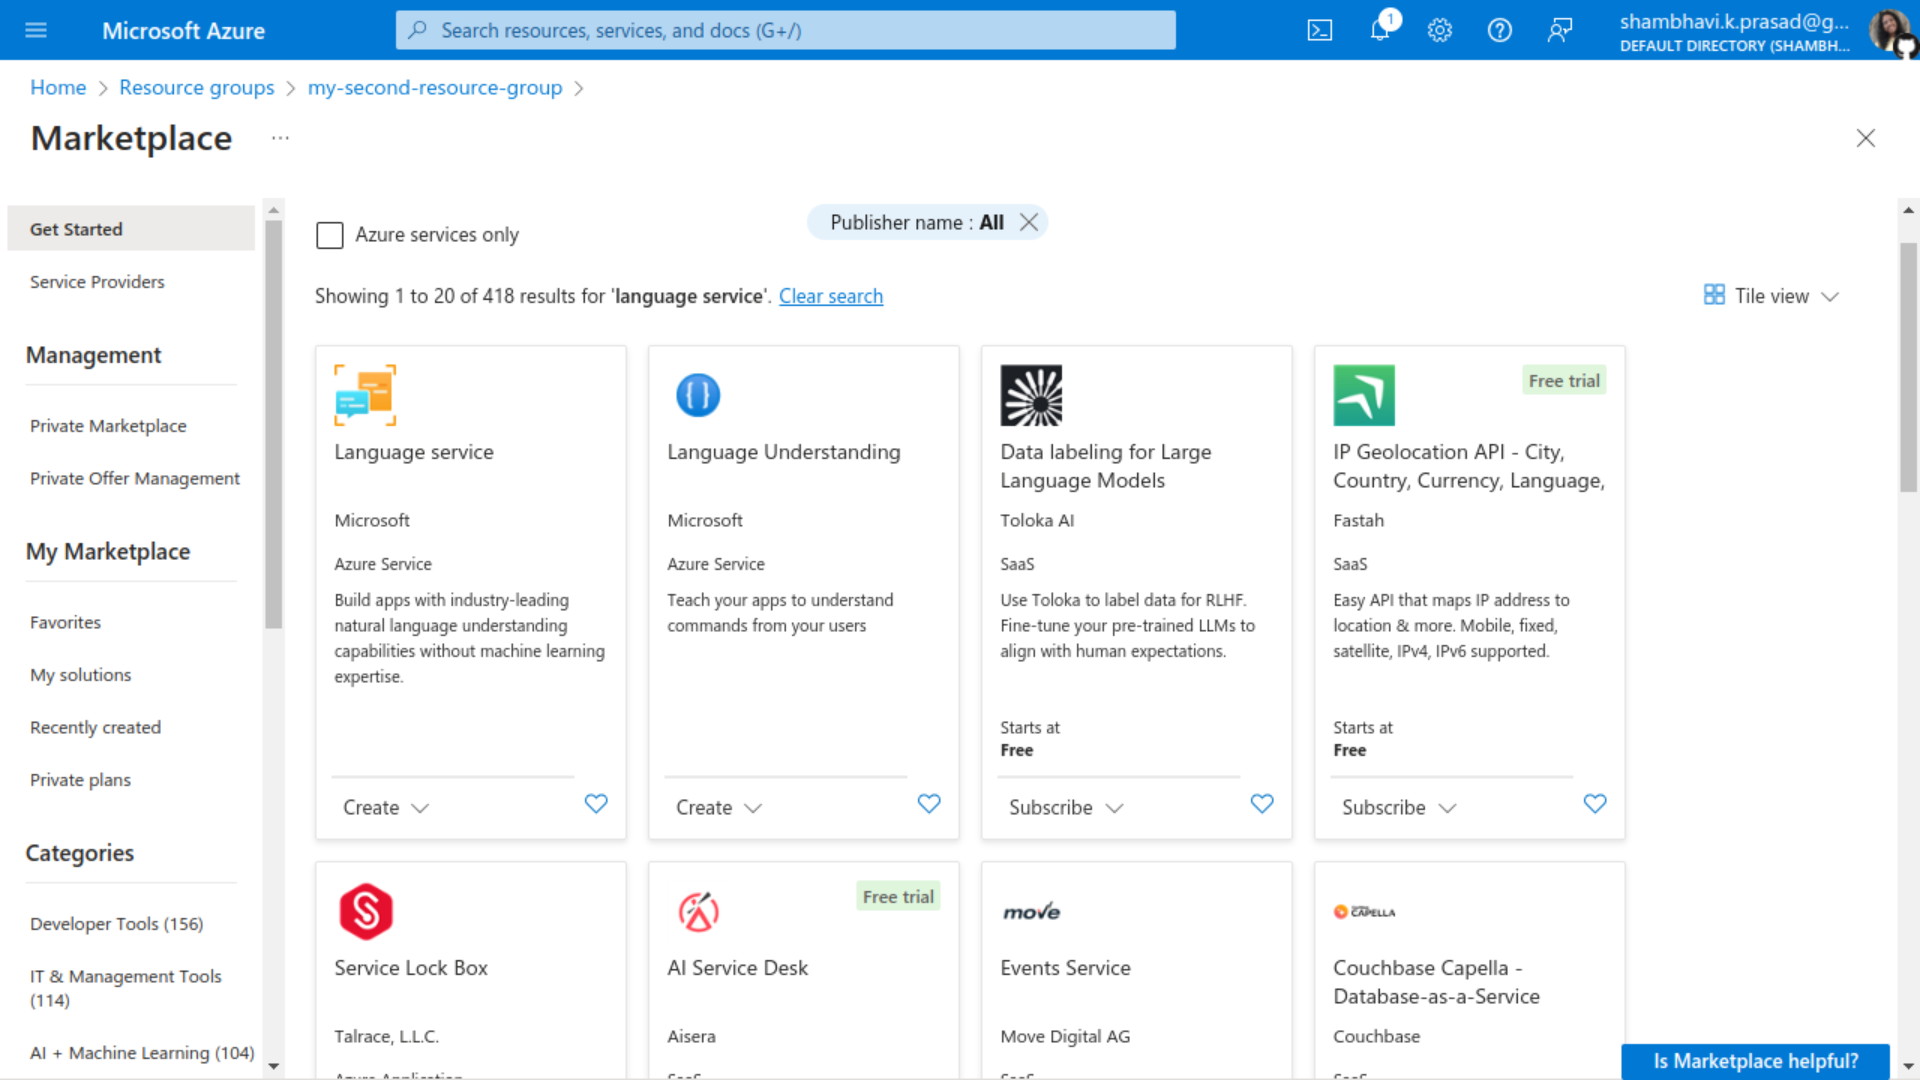

In [ ]:
img('clu1.png')

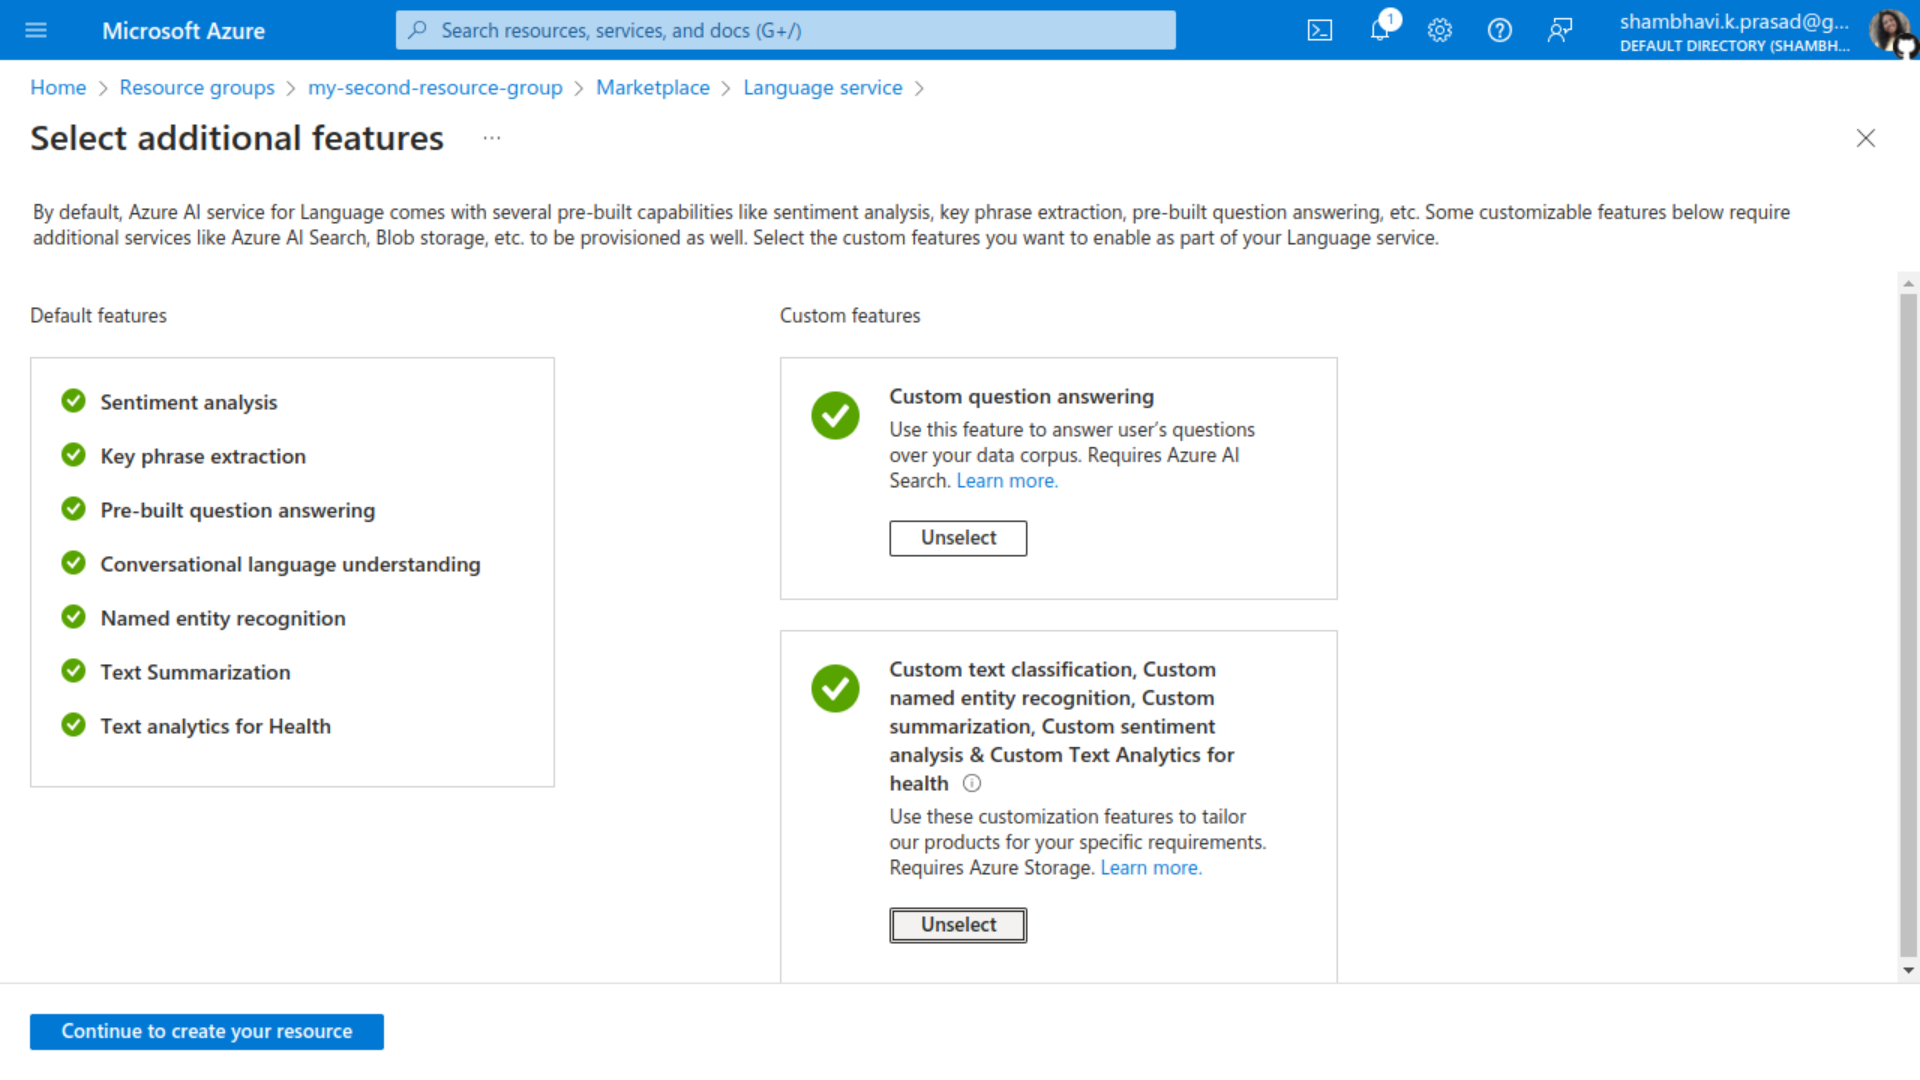

In [ ]:
img('clu2.png')

>  
> ### Please select the free pricing tier for your resource.
> ### Please select the Premium LRS for your storage account.

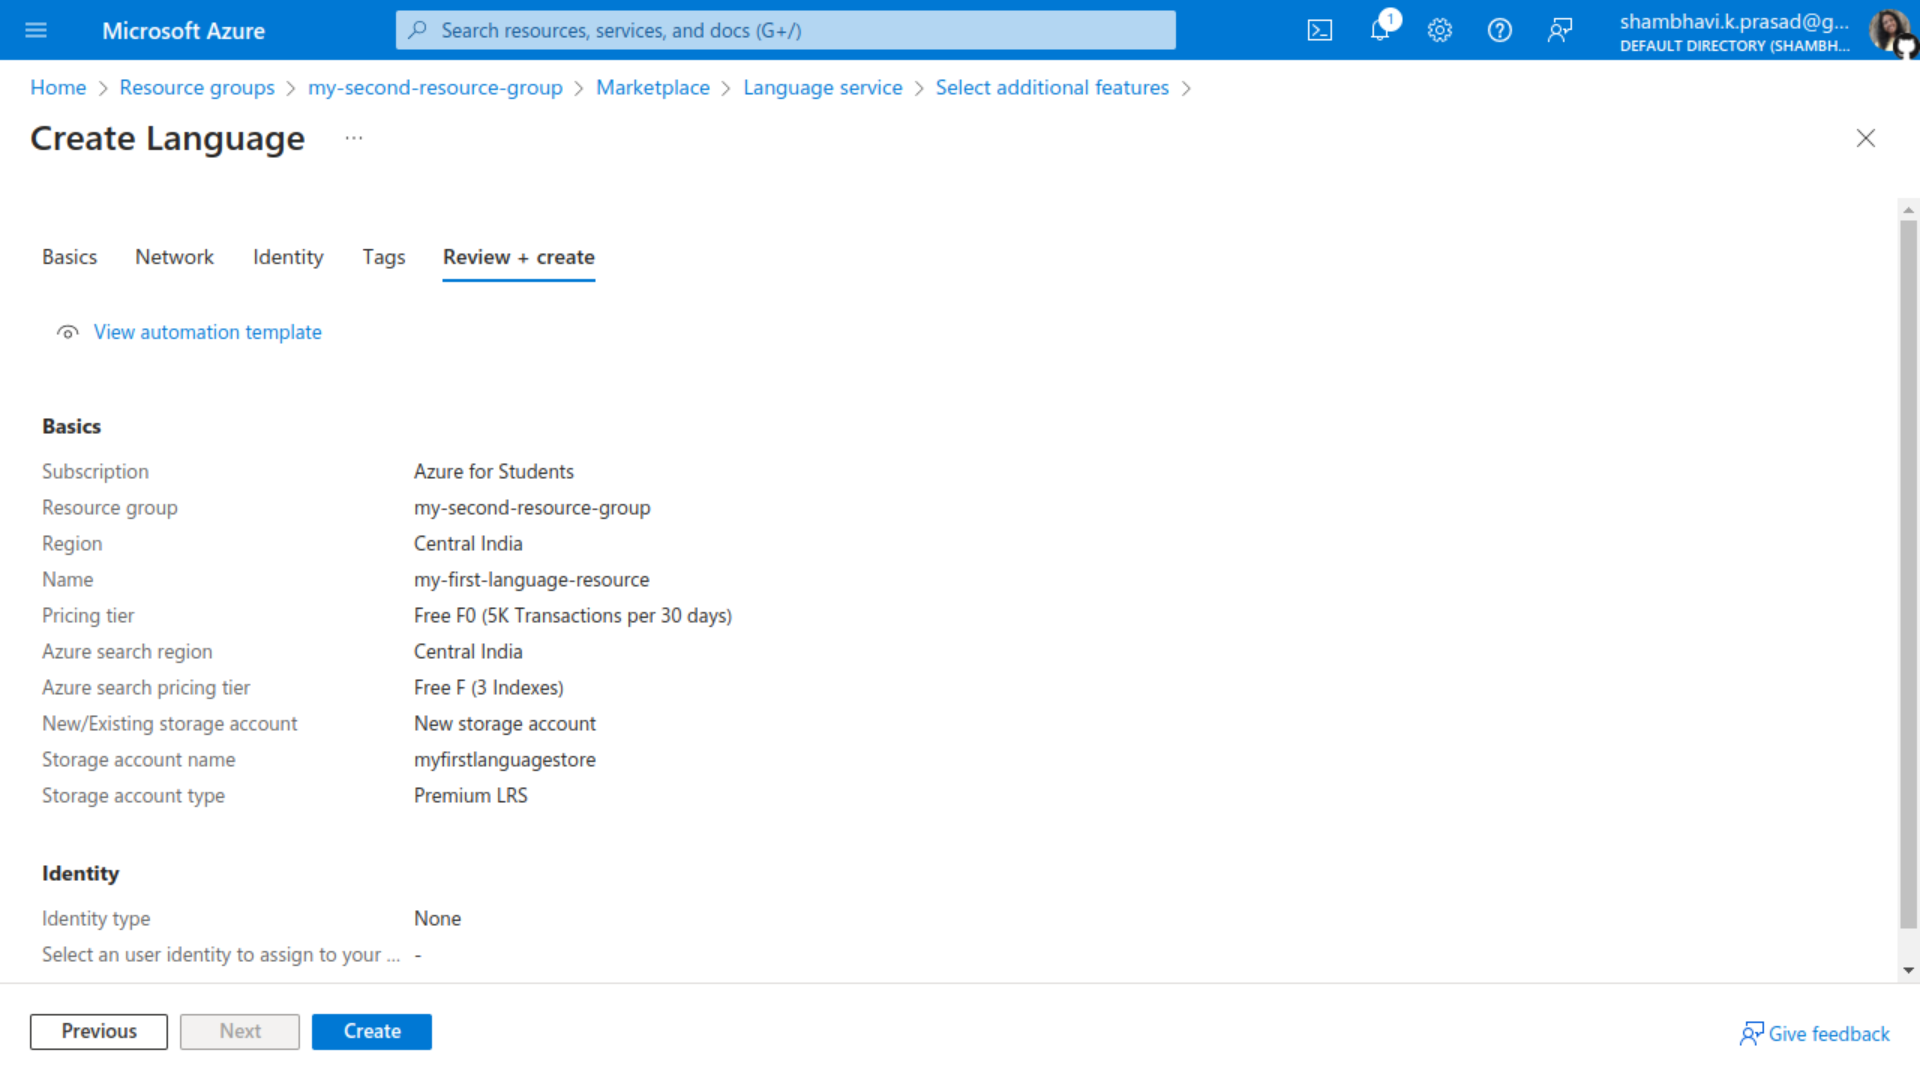

In [ ]:
img('clu5.png')

## After executing the above steps, you will see three resources in your resource group:


### 1.   Language resource
### 2.   Storage resource
### 3.   Search resource



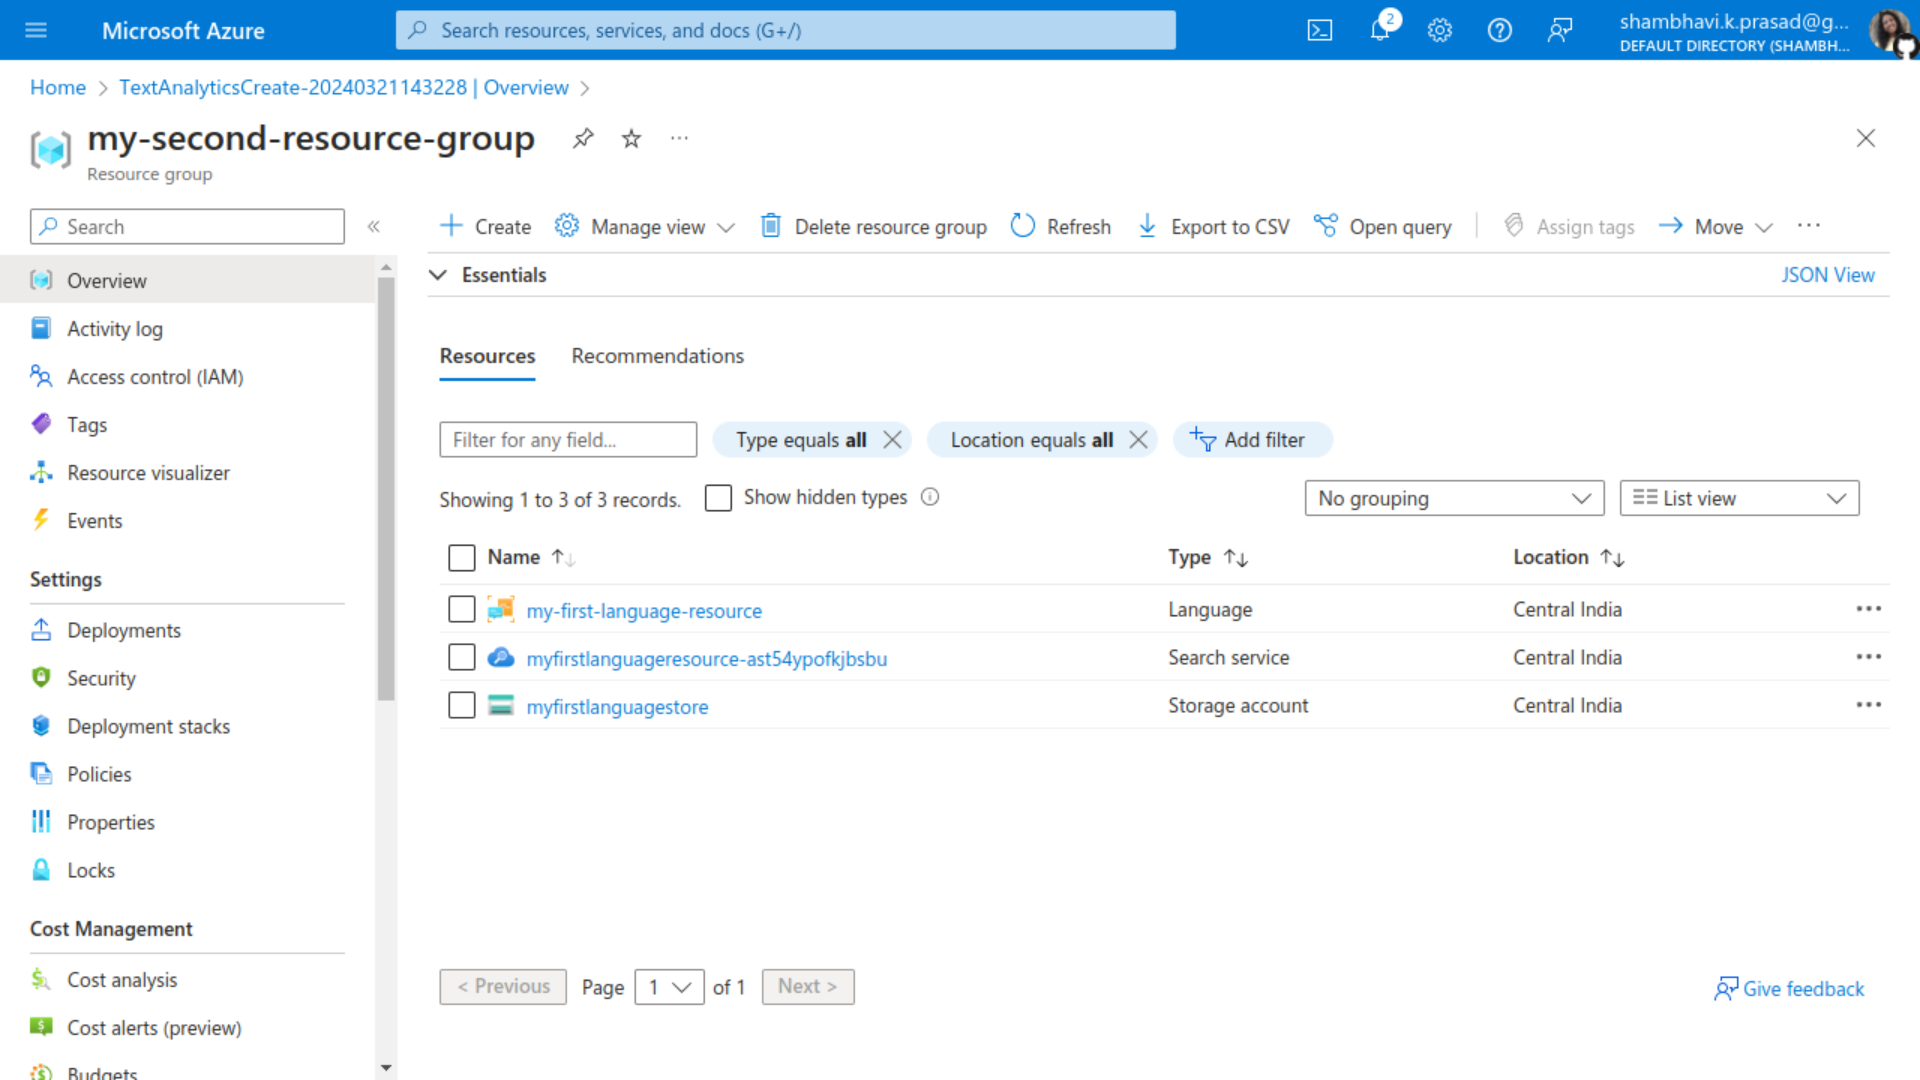

In [ ]:
img('clu6.png')

## Copy the subscription key and endpoint. Save them as environment variables, to authenticate and connect to the Language Service client.

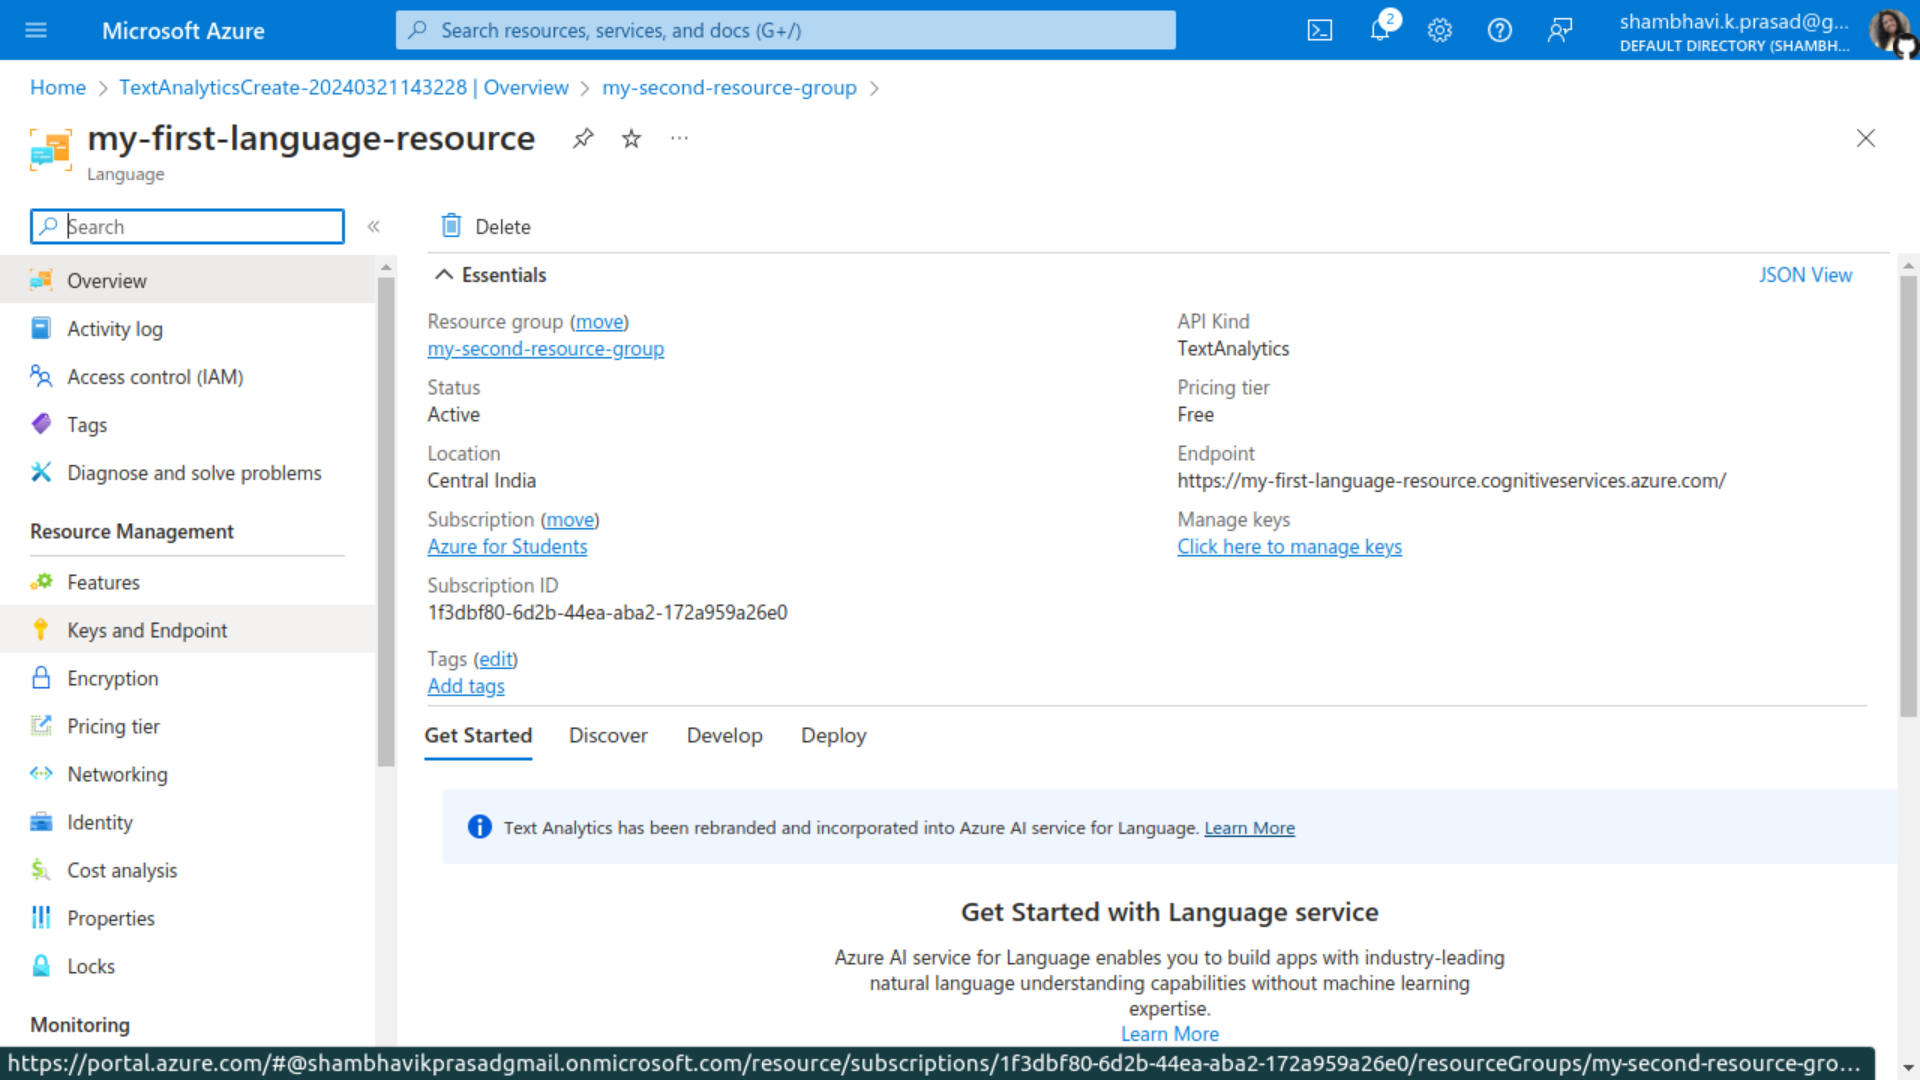

In [ ]:
img('clu9.png')

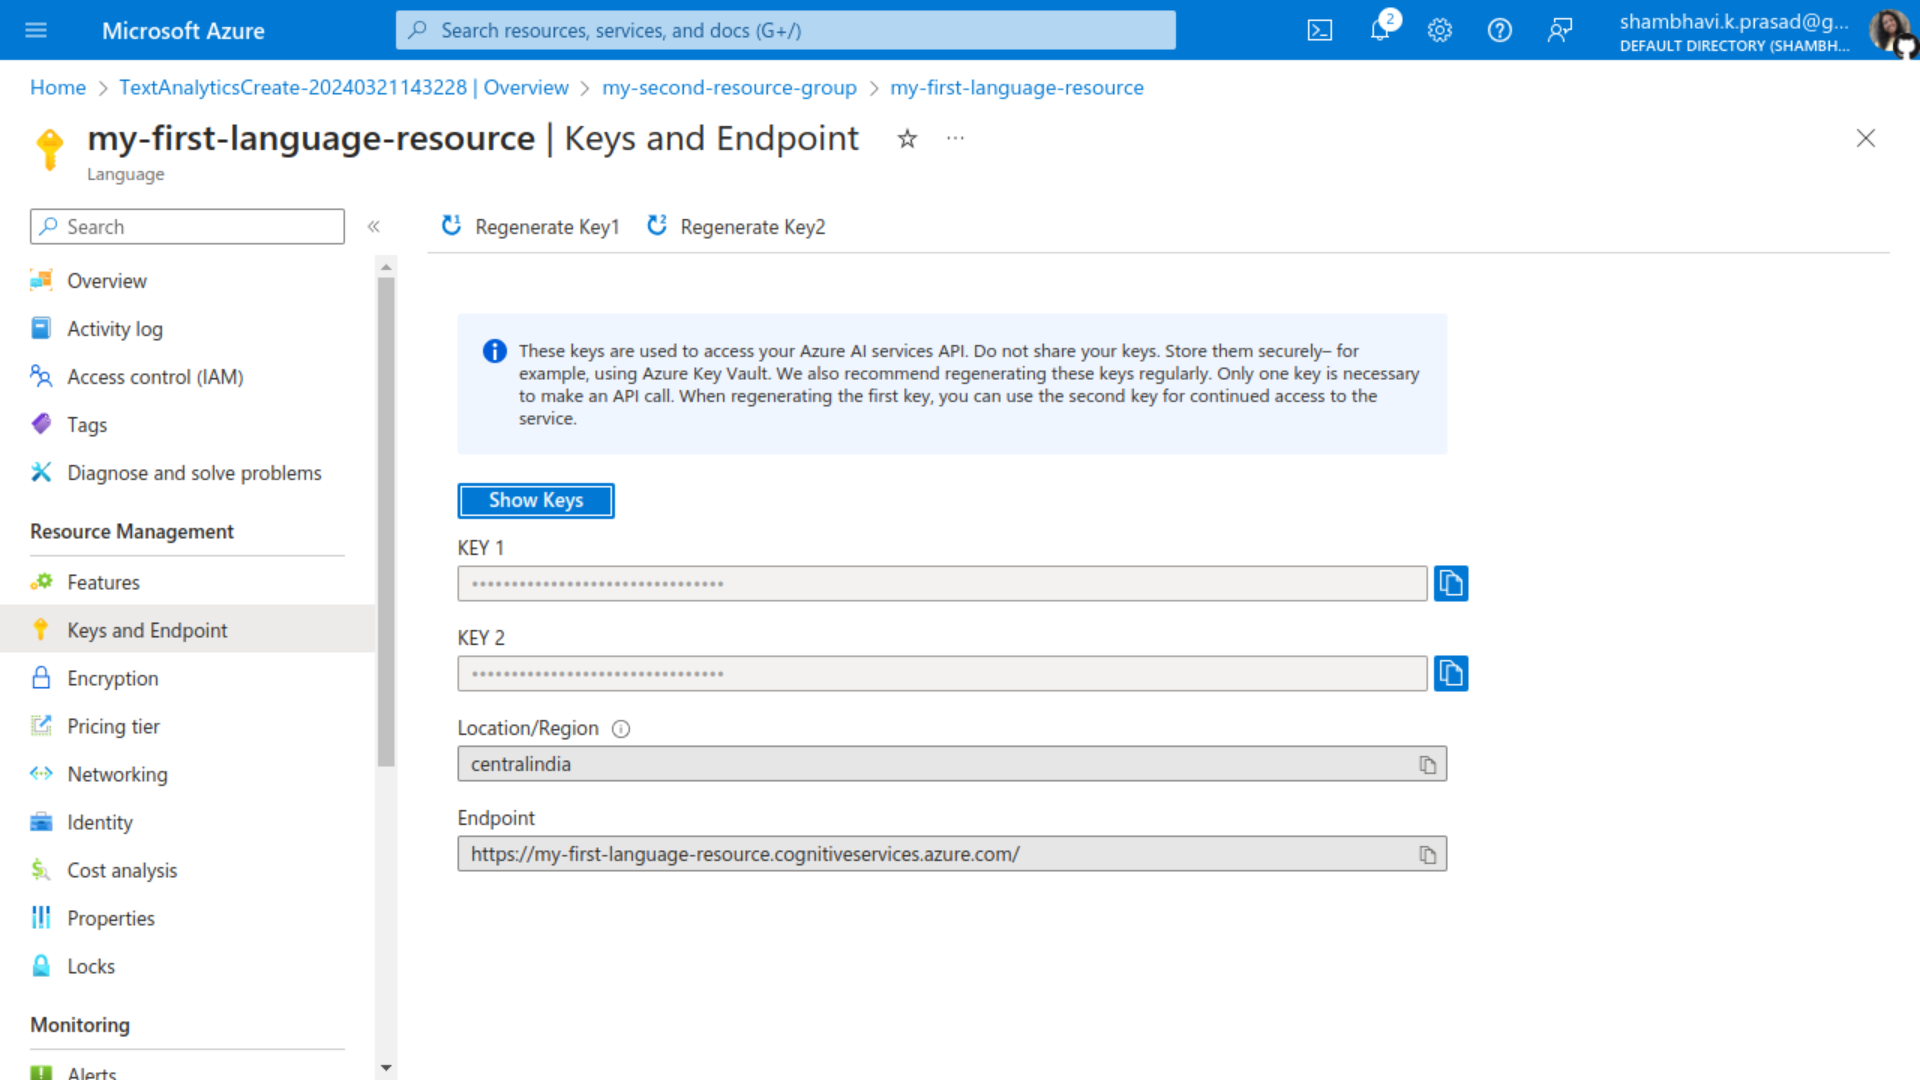

In [ ]:
img('clu10.png')

### How to save the keys as environment variables?
  1. Open a new instance of a word editor like Notepad.
  2. Enter the names of your variables (subscription_key and endpoint) and save their values as strings.
  3. Name the file as .env. Please note, this file will be hidden. To view it, kindly select the option to show hidden files.
  4. For reference, here is a screenshot of an env file.
  5. Import the file in your IDE, and read the values. For future runs, you will need to update this file with new values for subscription key and endpoint.

**Note:**
  1. We are going to create several clients throughout the course of the case study in this session. We will use the same endpoint and key, and use them to create different clients.


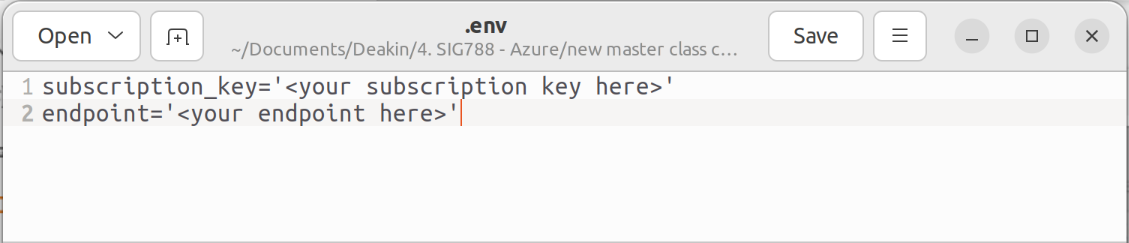

In [ ]:
img('env_sample1.png')

In [ ]:
# get service secrets
load_dotenv()
endpoint = os.environ.get("endpoint")
key = os.environ.get("subscription_key")

# Please note, we will create two clients, one for creating the project (Authoring) and one for querying it (Question Answering)

authoring_client = AuthoringClient(endpoint, AzureKeyCredential(key))
qna_client = QuestionAnsweringClient(endpoint, AzureKeyCredential(key))

## Case Study

## Now that your resource is created, go to the Language Studio https://language.cognitive.azure.com/home

### Select your resource to access the studio.

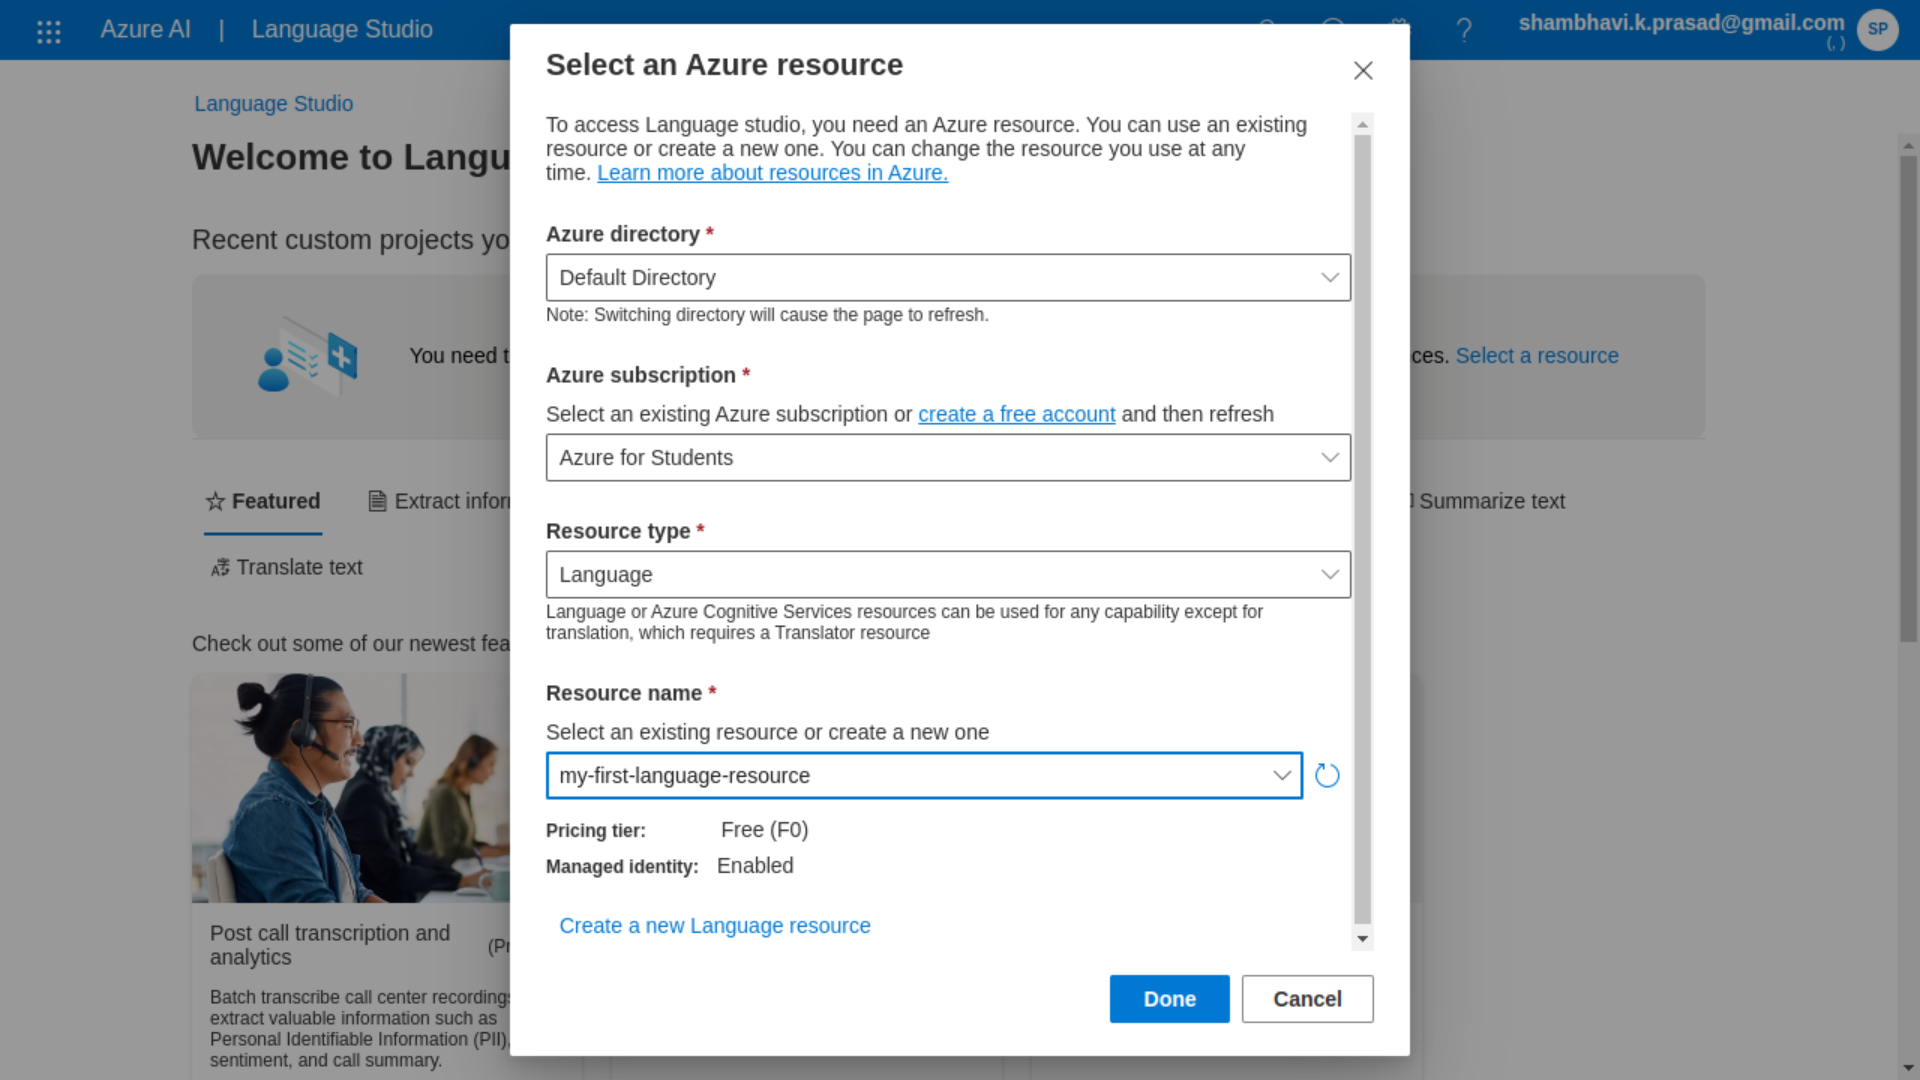

In [ ]:
img('clu7.png')

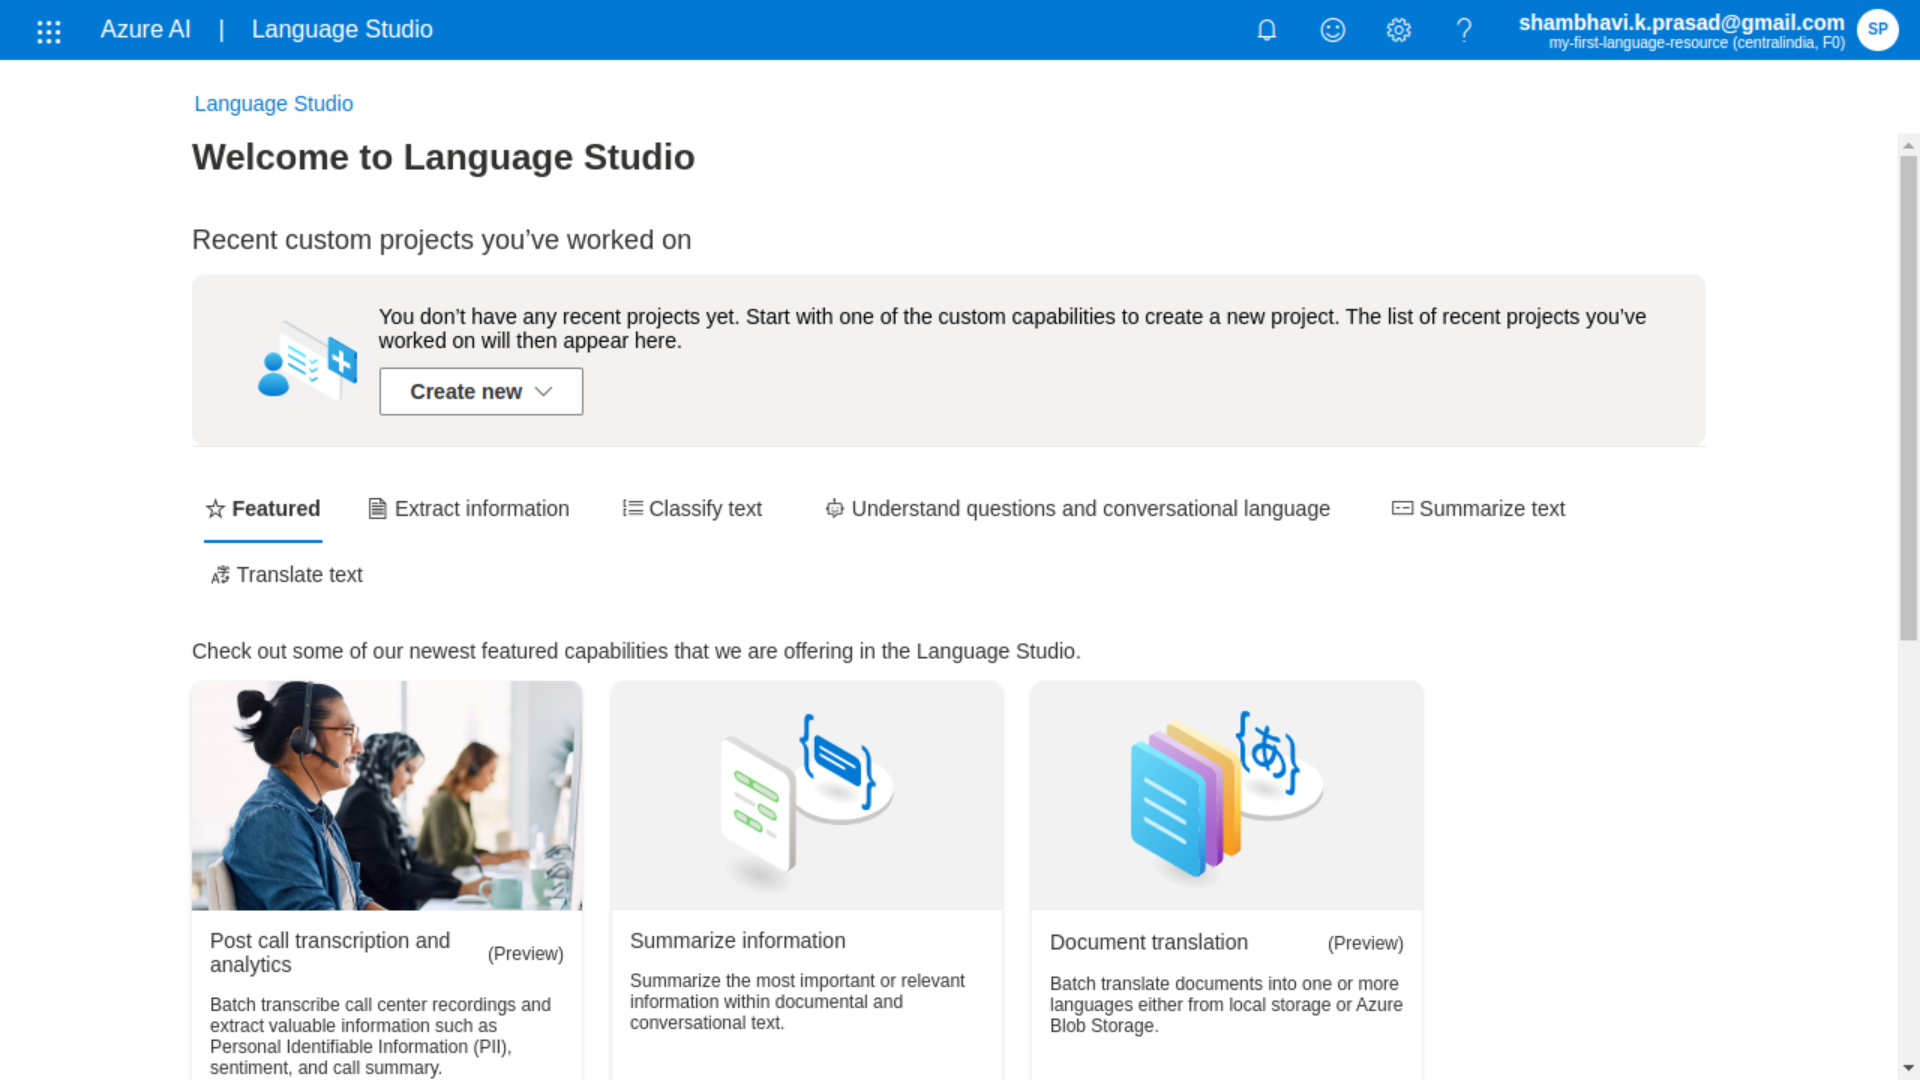

In [ ]:
img('clu11.png')

In [ ]:
# Create new project, add knowldege base and deploy it.

authoring_client = AuthoringClient(endpoint, AzureKeyCredential(key))

with authoring_client:

    # Step 1: create project

    print("\n********************** Creating a new project *********************")
    project_name = "AzureFAQs"
    project = authoring_client.create_project(
        project_name=project_name,
        options={
            "description": "FAQs related to Azure (MS Learn and CLU)",
            "language": "en",
            "multilingualResource": True,
            "settings": {
                "defaultAnswer": "no answer"
            }
        })

    # Output 1: View the project details

    print("view created project info:")
    print("\tname: {}".format(project["projectName"]))
    print("\tlanguage: {}".format(project["language"]))
    print("\tdescription: {}".format(project["description"]))

    # Step 2: Add a knowledge base
    print("\n********************* Adding a knowledge base *********************")

    # We are adding two knowledge bases here. A minimum of one knowledge base is required.
    # Please note, the knowledge base cannot have more than 3 sources (urls, files) in Free Tier.
    # In other words, you can add upto three sources/indices in one project, under the free tier.

    update_sources_poller = authoring_client.begin_update_sources(
        project_name=project_name,
        sources=[
            {
                "op": "add",
                "value": {
                    "displayName": "Azure MS Learn FAQ",
                    "sourceUri": "https://learn.microsoft.com/en-us/training/support/faq?pivots=general",
                    "sourceKind": "url"
                }
            },
            {
                "op": "add",
                "value": {
                    "displayName": "CLU FAQ",
                    "sourceUri": "https://learn.microsoft.com/en-us/azure/ai-services/language-service/conversational-language-understanding/faq",
                    "sourceKind": "url"
                }
            }
        ]
    )
    update_sources_poller.result()

    # Output 2: list sources
    print("\nlist project sources")
    sources = authoring_client.list_sources(
        project_name=project_name
    )
    for source in sources:
        print("knowledge base name: {}".format(source["displayName"]))
        print("\tsource: {}".format(source["source"]))
        print("\tsource Uri: {}".format(source["sourceUri"]))
        print("\tsource kind: {}".format(source["sourceKind"]))


    # Step 3: deploy the project

    print("\n********************** Deploying the project **********************")

    deployment_poller = authoring_client.begin_deploy_project(
        project_name=project_name,
        deployment_name="production"
    )
    deployment_poller.result()

    # list all deployments
    deployments = authoring_client.list_deployments(
        project_name=project_name
    )

    print("view project deployments")
    for d in deployments:
        print(d)



********************** Creating a new project *********************
view created project info:
	name: AzureFAQs
	language: en
	description: FAQs related to Azure (MS Learn and CLU)

********************* Adding a knowledge base *********************

list project sources
knowledge base name: Azure MS Learn FAQ
	source: https://learn.microsoft.com/en-us/training/support/faq?pivots=general
	source Uri: https://learn.microsoft.com/en-us/training/support/faq?pivots=general
	source kind: url
knowledge base name: CLU FAQ
	source: https://learn.microsoft.com/en-us/azure/ai-services/language-service/conversational-language-understanding/faq
	source Uri: https://learn.microsoft.com/en-us/azure/ai-services/language-service/conversational-language-understanding/faq
	source kind: url

********************** Deploying the project **********************
view project deployments
{'deploymentName': 'production', 'lastDeployedDateTime': '2024-03-22T10:51:50Z'}


## View the project on the Language Studio:
1. Navigate to https://language.cognitive.azure.com/home
2. Before executing the above steps, we can see that the Language Studio had no projects. Now, you can see your project created here.
3. Click on the project title to view the details like source name, url, and whether it is structured or unstructured.
4. Clicking on the source on this page shows you the questions and answers.

## We can now see that a project has been created on the Language Studio.

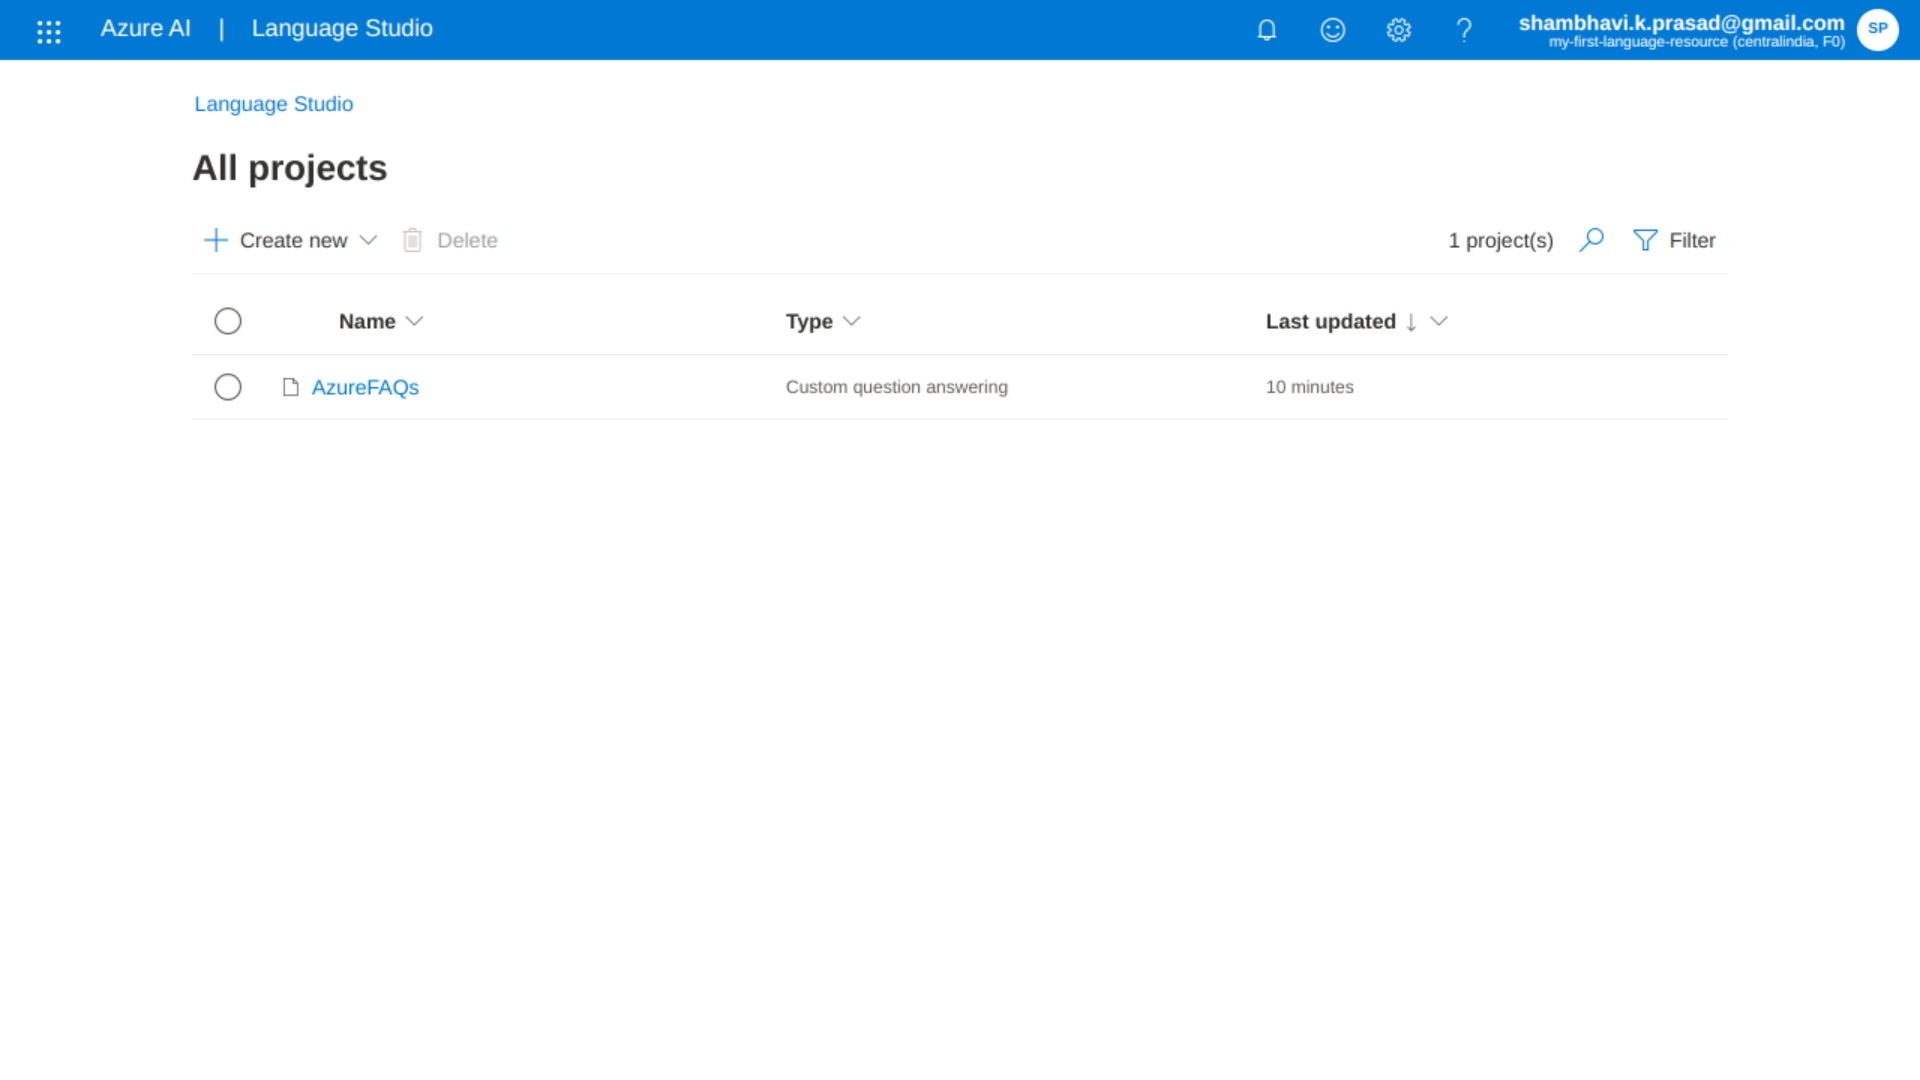

In [ ]:
img('clu16.png')

## While the above code is running, you can see that the sources in the project are empty. After the associated code completes execution, this page will be updated with the knowledge base.

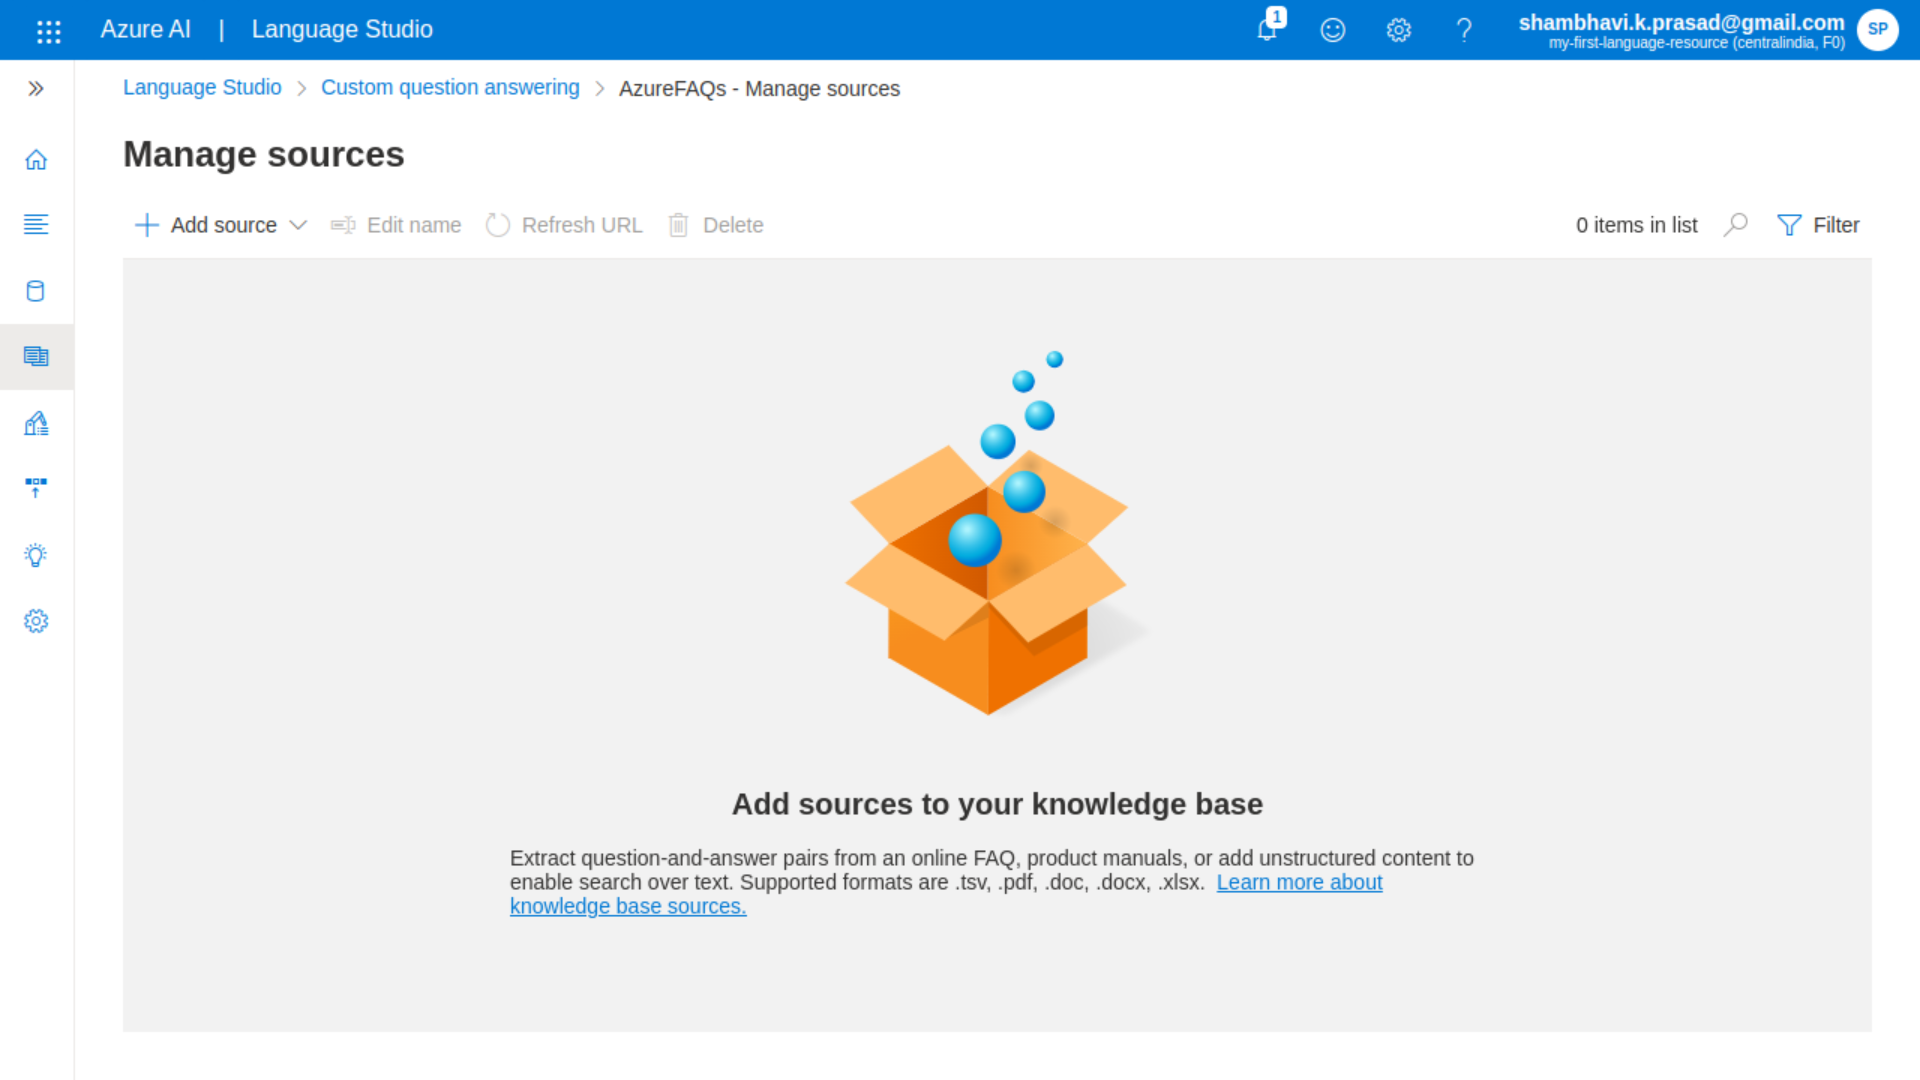

In [ ]:
img('clu15.png')

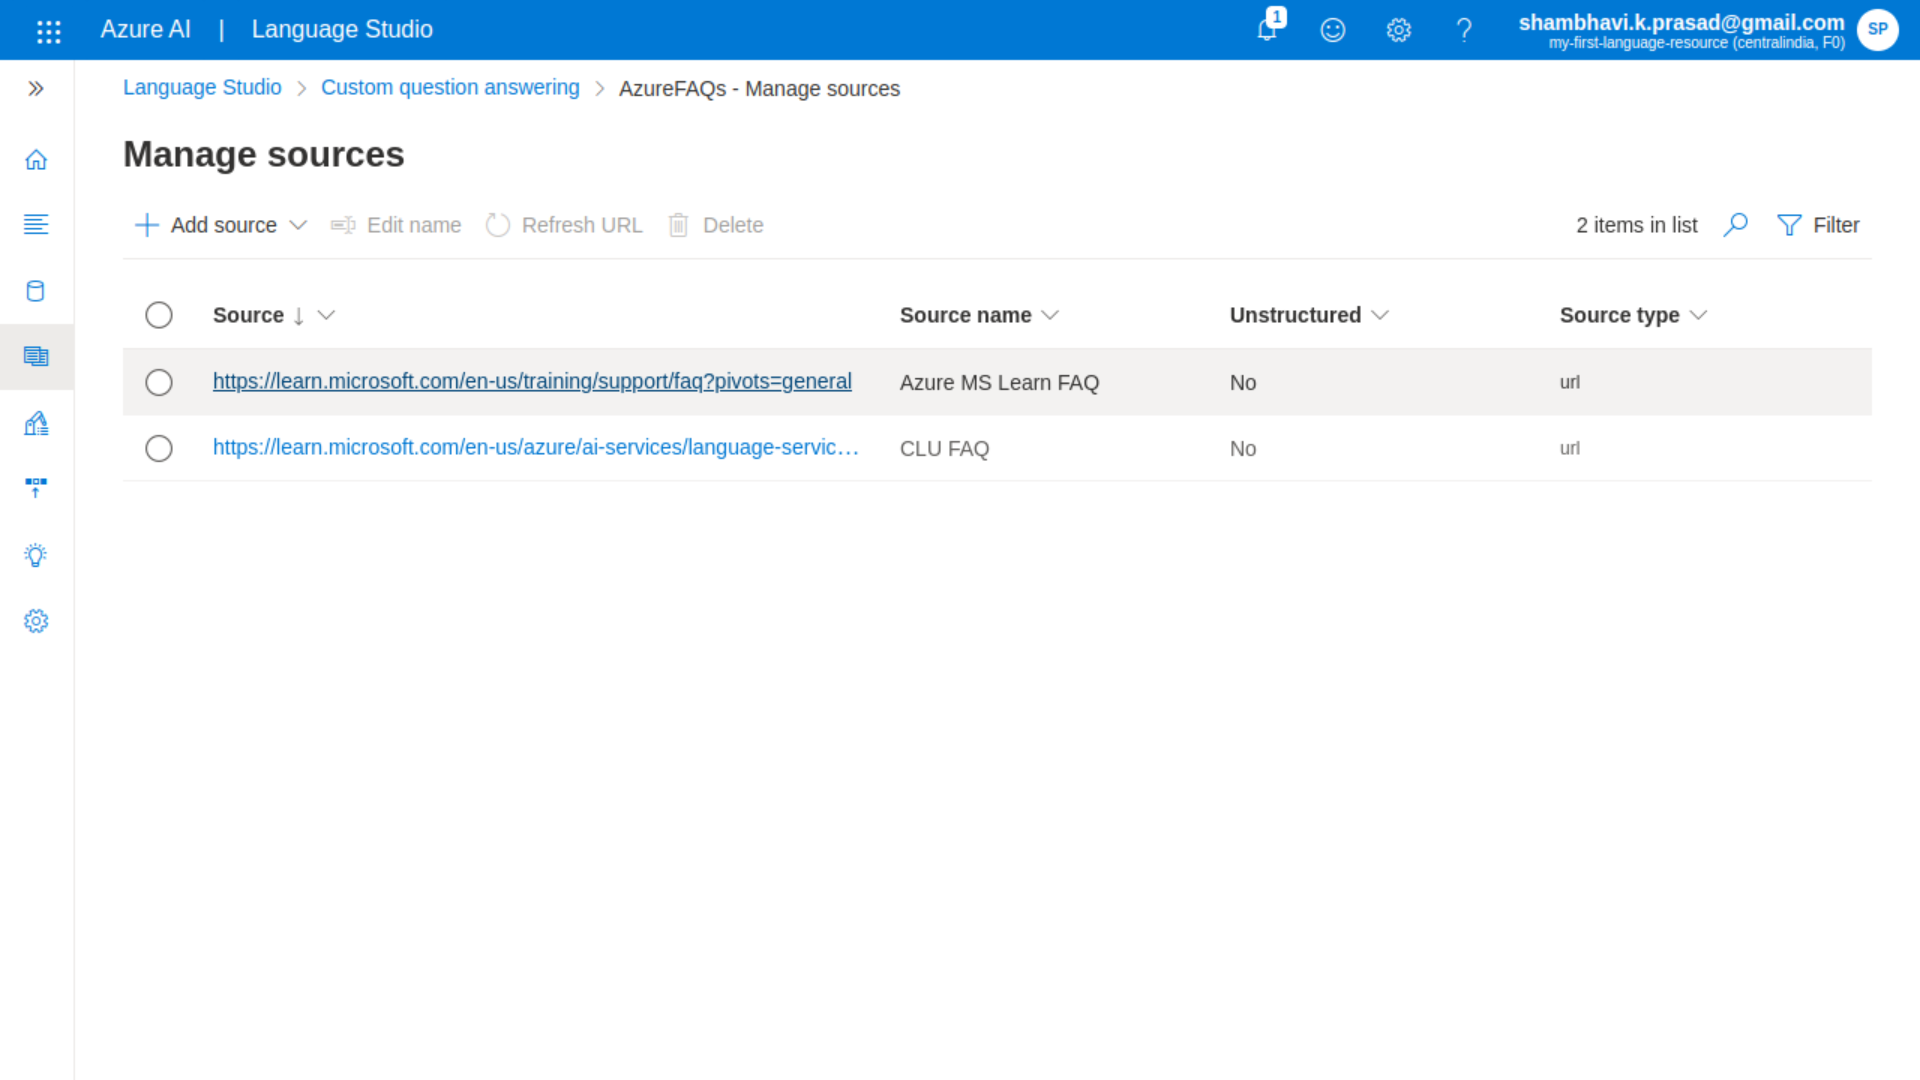

In [ ]:
img('clu17.png')

## On clicking on the source of the knowledge base, we can view the corpus of questions and answers. We can select a question from this base to test our program. We can also choose to rephrase the question. Alternatively, we can ask a question that is not present in the corpus, to test how well the answers are generated.

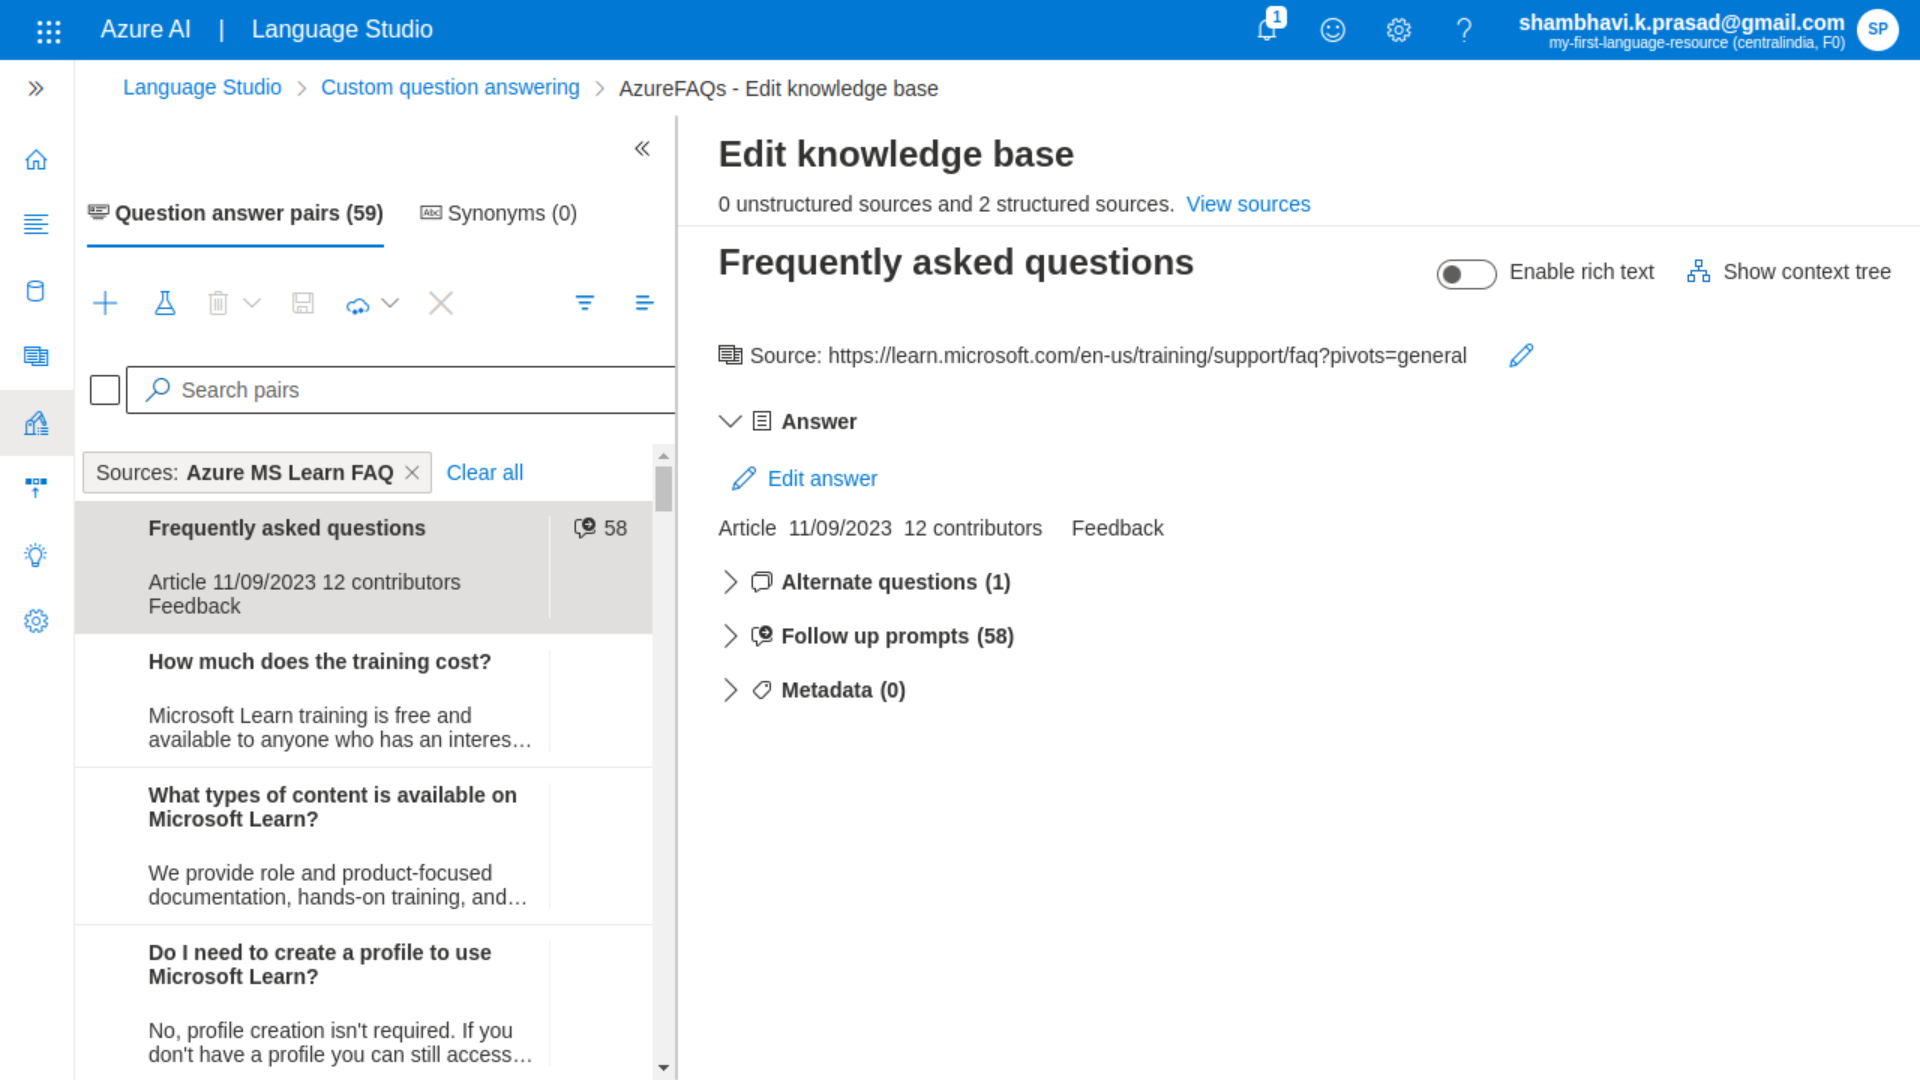

In [ ]:
img('clu18.png')

## After your knowledge base is deployed, you can see the deployment details in the Studio. As a next step, you can choose to create a chatbot using this corpus. In the current case study, we will not create a chatbot, but just access the corpus.

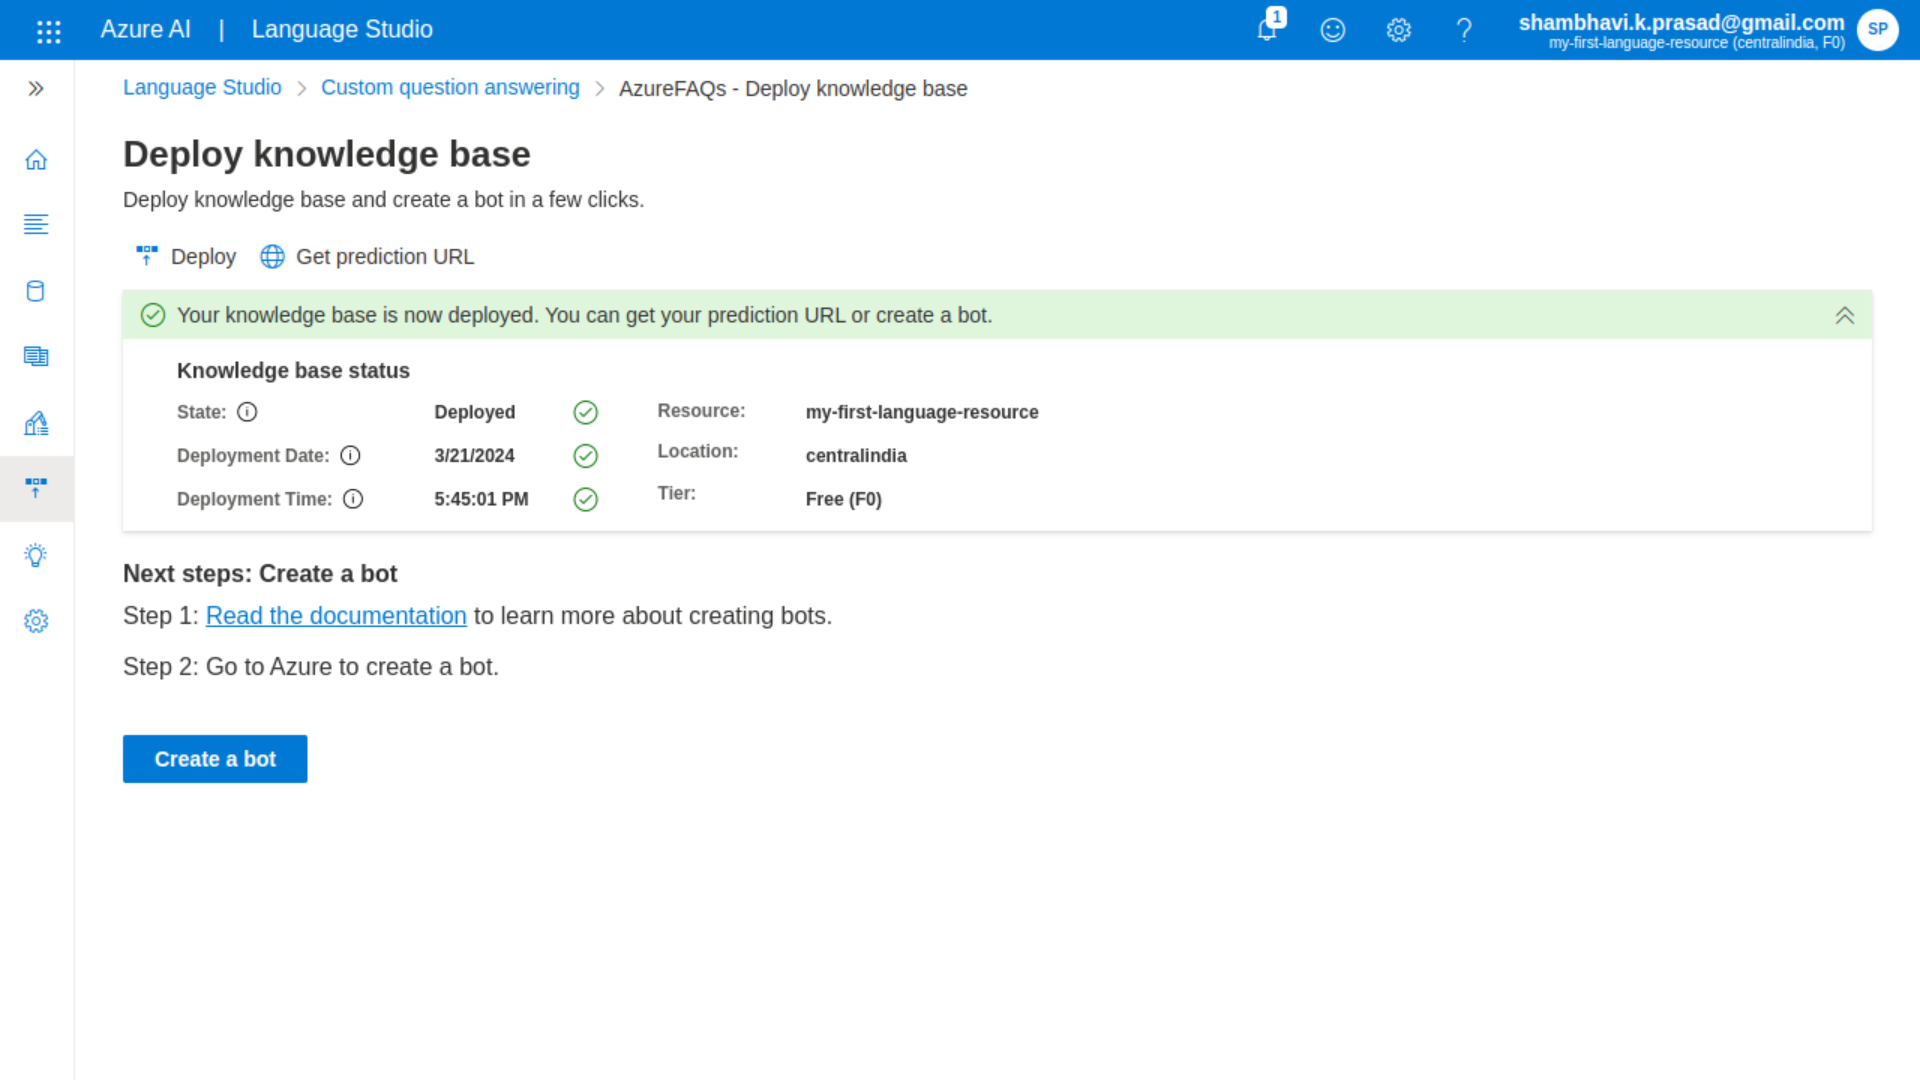

In [ ]:
img('clu19.png')

## Testing the project:
### 1. We can test by asking just one question.
### 2. We can initiate a chit-chat with the project, in which you can ask additional questions. This method will be useful when you want to create a chatbot.

### Changing the confidence threshold will change the way the answers are returned.

## 1. Test by asking one question:

In [ ]:
# 1. Test by asking a question
qna_client = QuestionAnsweringClient(endpoint, AzureKeyCredential(key))

with qna_client:
    question= "How do I create a project in CLU?"
    output = qna_client.get_answers(
        question=question,
        top=3,
        confidence_threshold=0.5,
        include_unstructured_sources=True,
        short_answer_options=qna.ShortAnswerOptions(
            confidence_threshold=0.5,
            top=1
        ),
        project_name="AzureFAQs",
        deployment_name="test"
    )
    if output.answers:
        best_candidate = [a for a in output.answers if a.confidence and a.confidence > 0.5][0]
        print("Q: {}".format(question))
        print("A: {}".format(best_candidate.answer))
    else:
        print(f"No answers returned from question '{question}'")

Q: How do I create a project in CLU?
A: See the [quickstart](https://learn.microsoft.com/en-us/azure/ai-services/language-service/conversational-language-understanding/quickstart) to quickly create your first project, or the [how-to article](https://learn.microsoft.com/en-us/azure/ai-services/language-service/conversational-language-understanding/how-to/create-project) for more details.


## 2. Test by creating a chit-chat:

In [ ]:
# 2. Testing by initiating a chit-chat.

qna_client = QuestionAnsweringClient(endpoint, AzureKeyCredential(key))
with qna_client:
    first_question= "What is a learning path?"

    output = qna_client.get_answers(
        question=first_question,
        top=3,
        confidence_threshold=0.5,
        include_unstructured_sources=True,
        short_answer_options=qna.ShortAnswerOptions(
            confidence_threshold=0.5,
            top=1
        ),
        project_name="AzureFAQs",
        deployment_name="test"
    )
    if output.answers:
        best_candidate = [a for a in output.answers if a.confidence and a.confidence > 0.2][0]
        print(u"Q: {}".format(first_question))
        print(u"A: {}".format(best_candidate.answer))
        print('\n***********************************************************************************\n')
    else:
        print(f"No answers returned from question '{first_question}'")


    if best_candidate.qna_id:
        followup_question = "Why is my project taking so long to train?"

        output = qna_client.get_answers(
            question=followup_question,
            top=3,
            confidence_threshold=0.5,
            answer_context=qna.KnowledgeBaseAnswerContext(
                previous_question=first_question,
                previous_qna_id=best_candidate.qna_id
            ),
            short_answer_options=qna.ShortAnswerOptions(
                confidence_threshold=0.5,
                top=1
            ),
            include_unstructured_sources=True,
            project_name="AzureFAQs",
            deployment_name="test"
        )
        if output.answers:
            print(u"Q: {}".format(followup_question))
            print(u"A: {}".format(output.answers[0].answer))
            print('\n***********************************************************************************\n')
        else:
            print(f"No answers returned from question '{followup_question}'")


Q: What is a learning path?
A: Learning paths are collections of training modules that are organized around specific roles (like developer, architect, or system admin) or technologies (like Azure Web Apps, Power BI, or Xamarin.Forms). When you finish a learning path, you've gained a new understanding of different aspects of the technology or role you're studying. You also get an achievement trophy!

***********************************************************************************

Q: Why is my project taking so long to train?
A: For conversation projects, long training times are expected. Based on the number of examples you have your training times may vary from 5 minutes to 1 hour or more.

***********************************************************************************



# Closing the project - resource deletion

### Please note, this notebook a part of a two-part series. If you wish to continue with the second part immediately, we would suggest that you keep the resource. If you intend to continue the second part at a later time, please proceed with the step of resource deletion now.